# This notebook is to explore the multiple lists of critical genes identified by ASSIST workflow with network subselection + subnetwork embedding

In [1]:
import sys
sys.path.append("../..")
import pandas as pd
import os
from itertools import combinations
from sys import platform 
prefix = 'G:' if platform == 'win32' else '/Volumes/GoogleDrive'
from src.eda.eda_functions import jaccard_similarity
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [68]:
# load critical gene lists and embedding names
critical_gene_dfs = []
embedding_names = []
critical_gene_path = prefix + '/Shared drives/NIAAA_ASSIST/Data/feature_extraction_derived/'
for file in os.listdir(critical_gene_path):
    if file.endswith('.csv'):
        critical_gene_dfs.append(pd.read_csv(critical_gene_path + file))
        emb_name = '_'.join(file.split('_')[:3])
        embedding_names.append(emb_name)

In [69]:
comm_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/eda_derived/network_louvain_default.csv')

In [70]:
critical_gene_dfs_w_module = []
for df in critical_gene_dfs:
    merged_df = pd.merge(df, comm_df, left_on = 'gene', right_on = 'id')
    critical_gene_dfs_w_module.append(merged_df)

# Determine the original module id for the critical genes for each embedding

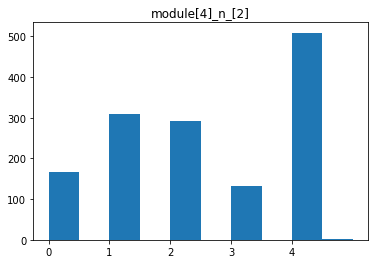

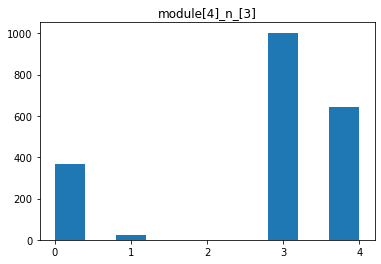

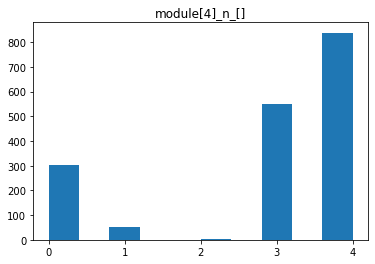

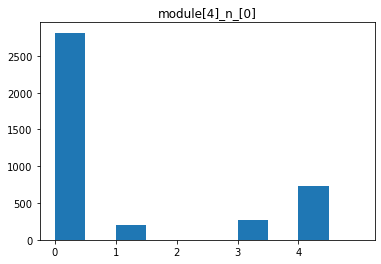

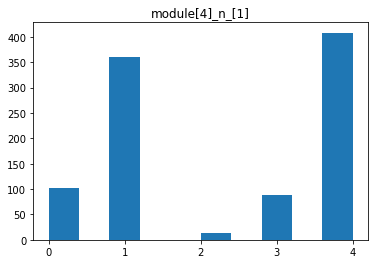

In [29]:
for i in range(len(critical_gene_dfs)):
    plt.hist(critical_gene_dfs_w_module[i]['louvain_label'])
    plt.title(embedding_names[i])
    plt.xticks([x for x in range(5)])
    plt.show()
    plt.close();

# Critical gene importance: how to rank them
## 1. Common ones between the models?
## 2. Common ones between the embeddings regardless of the rank
## 3. Centrality of the nodes in the original network?

In [35]:
critical_gene_sets = [set(critical_gene_dfs_w_module[i]['gene']) for i in range(5)]
common_critical_genes_all_emb = list(set.intersection(*critical_gene_sets))

In [39]:
# critical genes shared by all embeddings and their original module id (ranking is ignored here)
comm_df[comm_df.id.isin(common_critical_genes_all_emb)]

,id,louvain_label
266,ENSG00000173369,4
338,ENSG00000117758,0
1354,ENSG00000158710,4
1395,ENSG00000203747,4
1646,ENSG00000133048,4
2312,ENSG00000122862,4
2852,ENSG00000167244,4
9047,ENSG00000099860,4
9830,ENSG00000125753,4
14816,ENSG00000145623,4


# Plot # of common critical genes between each pair of embeddings: embeddings with high ML scores tend to share more critical genes in common

In [191]:
common_gene_cnt = []
embedding_comparisons = []
for a, b in combinations([0,1,2,3,4], 2):
    critical_gene_sets = [set(critical_gene_dfs_w_module[i]['gene']) for i in [a,b]] 
    common_gene_cnt.append(len(set.intersection(*critical_gene_sets)))
    embedding_comparisons.append(f'{embedding_names[a]} vs {embedding_names[b]}')

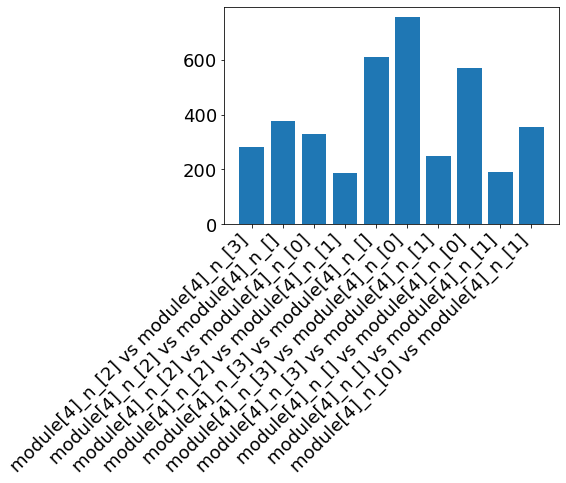

In [192]:
plt.bar(embedding_comparisons, common_gene_cnt)
plt.xticks(rotation = 45, ha='right');

## Same as above, except only the top 50 critical genes are considered

In [193]:
common_gene_cnt = []
embedding_comparisons = []
for a, b in combinations([0,1,2,3,4], 2):
    critical_gene_sets = [set(critical_gene_dfs_w_module[i]['gene'][:50]) for i in [a,b]] 
    common_gene_cnt.append(len(set.intersection(*critical_gene_sets)))
    embedding_comparisons.append(f'{embedding_names[a]} vs {embedding_names[b]}')

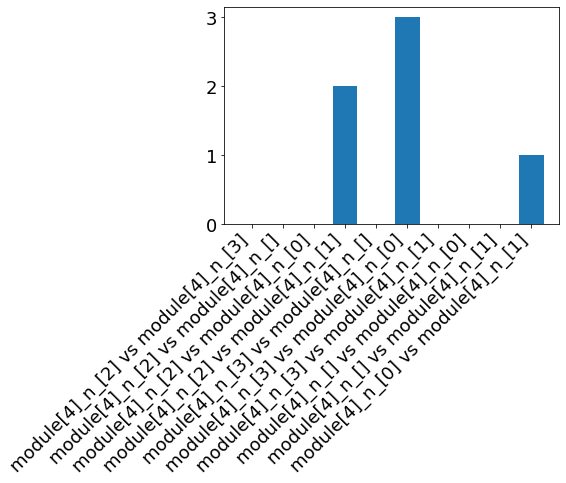

In [194]:
plt.bar(embedding_comparisons, common_gene_cnt)
plt.xticks(rotation = 45, ha='right');

# Check if the critical genes extracted from Deep Response Model are just the genes that share large weights with DEGs
## A sanity check to see that the DRM found other features to help identify critical genes

In [4]:
deseq = pd.read_excel(prefix + '/Shared drives/NIAAA_ASSIST/Data/deseq.alc.vs.control.age.rin.batch.gender.PMI.corrected.w.prot.coding.gene.name.xlsx')

In [5]:
def join_subnetwork_w_deseq(subnetwork, deseq):
    if 'abs_log2FC' not in deseq.columns:
        deseq['abs_log2FC'] = abs(deseq['log2FoldChange'])
    subnetwork_w_DE = pd.merge(subnetwork, deseq[['id','abs_log2FC']], left_index = True, right_on = 'id')
    subnetwork_w_DE.index = subnetwork_w_DE['id']
    return subnetwork_w_DE

In [6]:
def get_network_important_genes(subnetwork_w_de, cutoff = 0.03):
    network_important_gene_dict = {}
    for col in subnetwork_w_de.columns[:-2]:
        subset = subnetwork_w_de[(subnetwork_w_de[col].between(cutoff, 0.99)) & (subnetwork_w_de['abs_log2FC'] > 0.2)][col]
        if len(subset) > 0:
            network_important_gene_dict[col] = len(subset)
    return network_important_gene_dict

In [7]:
def plot_critical_n_important_gene_jaccard(critical_gene_dfs, network_important_gene_dicts, embedding_names):
    '''Jaccard to determine overlap between critical genes found by DRM and in the original network'''
    jac_list = []
    for i in range(len(critical_gene_dfs)):
        jac = jaccard_similarity(critical_gene_dfs[i].gene.tolist(), network_important_gene_dicts[i].keys())
        jac_list.append(jac)
    plt.figure
    plt.bar(embedding_names, jac_list)
    plt.xticks(rotation = 45, ha = 'right')
    plt.ylabel('jaccard similarity')
    plt.rcParams.update({'font.size':18})
    plt.title('Critical genes vs important genes')

In [60]:
subnetwork_path = prefix + '/Shared drives/NIAAA_ASSIST/Data/eda_derived/subnetworks_Jan_14/'
subnetwork_dfs = []
subnetwork_names = []
for file in ['deg_mod=[4],non_deg_mod=[2],num_genes=150,min_weight=0.01.csv', 'deg_mod=[4],non_deg_mod=[3],num_genes=150,min_weight=0.02.csv',
             'deg_mod=[4],non_deg_mod=[],num_genes=250,min_weight=0.008.csv','deg_mod=[4],non_deg_mod=[0],num_genes=100,min_weight=0.015.csv', 'deg_mod=[4],non_deg_mod=[1],num_genes=125,min_weight=0.01.csv']:
    subnetwork = pd.read_csv(subnetwork_path + file, index_col = 0)
    subnetwork_dfs.append(subnetwork)
    module_name = ','.join(file.split('=')[1:3]).split(',')
    subnetwork_names.append(f'module{module_name[0]}_n_{module_name[2]}')

In [9]:
subnetwork_w_deseq_dfs = []
for subnetwork in subnetwork_dfs:
    subnetwork_w_deseq_dfs.append(join_subnetwork_w_deseq(subnetwork, deseq))

In [11]:
network_important_gene_list = []
for subnetwork_w_deseq in subnetwork_w_deseq_dfs:
    network_important_gene_list.append(get_network_important_genes(subnetwork_w_deseq, cutoff = 0.01))

In [12]:
network_important_gene_list[0]

{'ENSG00000166819': 8,
 'ENSG00000159423': 11,
 'ENSG00000158195': 16,
 'ENSG00000159658': 5,
 'ENSG00000157184': 14,
 'ENSG00000162407': 18,
 'ENSG00000162599': 10,
 'ENSG00000116641': 12,
 'ENSG00000158966': 10,
 'ENSG00000213625': 17,
 'ENSG00000172380': 20,
 'ENSG00000116729': 16,
 'ENSG00000174021': 17,
 'ENSG00000097033': 12,
 'ENSG00000069702': 17,
 'ENSG00000137936': 13,
 'ENSG00000143036': 20,
 'ENSG00000117519': 20,
 'ENSG00000079335': 18,
 'ENSG00000170989': 19,
 'ENSG00000168710': 17,
 'ENSG00000155366': 21,
 'ENSG00000134250': 22,
 'ENSG00000213240': 12,
 'ENSG00000163386': 10,
 'ENSG00000117289': 18,
 'ENSG00000184260': 8,
 'ENSG00000143603': 14,
 'ENSG00000163346': 19,
 'ENSG00000018625': 12,
 'ENSG00000162738': 4,
 'ENSG00000143149': 15,
 'ENSG00000213064': 5,
 'ENSG00000117592': 15,
 'ENSG00000185278': 1,
 'ENSG00000143337': 6,
 'ENSG00000135821': 11,
 'ENSG00000135838': 16,
 'ENSG00000116747': 11,
 'ENSG00000134376': 7,
 'ENSG00000159176': 3,
 'ENSG00000092969': 17,
 

In [32]:
top_10_important_gene_list = []
for i in range(len(network_important_gene_list)):
    top_10_sorted = dict(sorted(network_important_gene_list[i].items(), key = lambda item: item[1], reverse=True)[:10]).keys()
    top_10_important_gene_list.append(top_10_sorted)

In [62]:
expression_meta_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/eda_derived/expression_meta.csv', low_memory = False)

In [64]:
from src.eda.eda_functions import gene_set_phenotype_corr

Removing existing folder: output
Created folder output


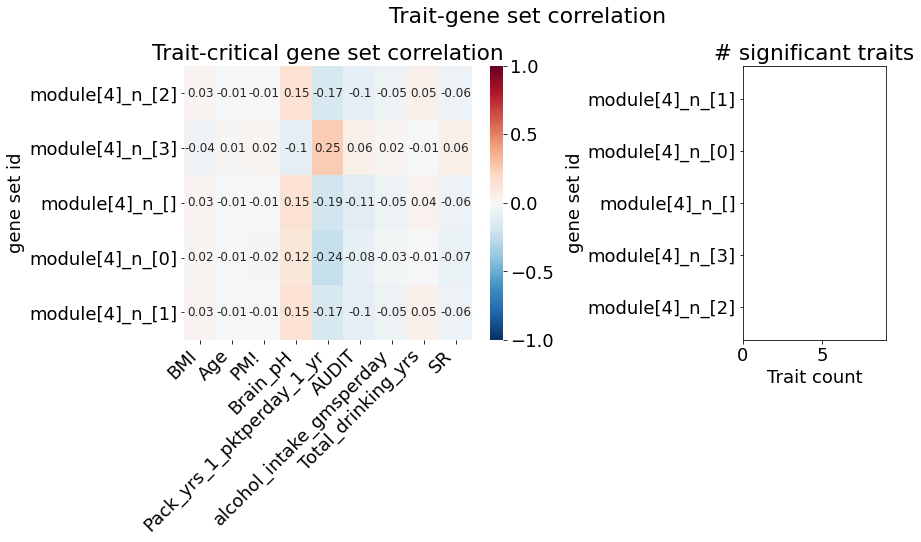

In [67]:
gene_set_phenotype_corr(top_10_important_gene_list, subnetwork_names, expression_meta_df, 'top 10 genes')

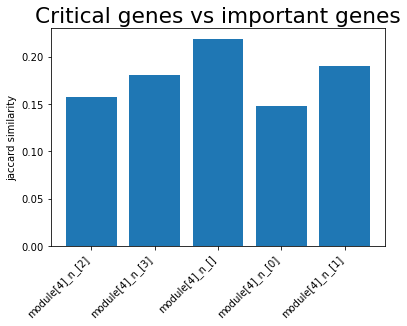

In [140]:
plot_critical_n_important_gene_jaccard(critical_gene_dfs_w_module, network_important_gene_list, embedding_names)

# Determine "important genes" from the original network without subsetting

In [95]:
%%time
tom_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/Kapoor_TOM.csv', index_col = 0) 

Wall time: 9min 59s


In [96]:
tom_df.head()

,ENSG00000227232,ENSG00000237683,ENSG00000241860,ENSG00000228463,ENSG00000225972,ENSG00000225630,ENSG00000237973,ENSG00000229344,ENSG00000248527,ENSG00000198744,...,ENSG00000226555,ENSG00000176728,ENSG00000217896,ENSG00000185275,ENSG00000131002,ENSG00000267793,ENSG00000260197,ENSG00000012817,ENSG00000229236,ENSG00000198692
ENSG00000227232,1.000000,0.000020,0.000030,0.000005,0.000073,3.861530e-05,0.000023,1.242536e-04,0.000057,0.000027,...,3.331294e-06,3.597243e-06,3.057570e-06,0.000014,3.406501e-06,2.426621e-06,2.787483e-06,4.098064e-06,3.525666e-06,3.664547e-06
ENSG00000237683,0.000020,1.000000,0.000502,0.000009,0.000014,4.467564e-06,0.000005,2.258114e-05,0.000017,0.000003,...,2.347299e-06,1.652009e-06,3.248601e-06,0.000005,1.489917e-06,1.919215e-06,1.754257e-06,1.478108e-06,1.977784e-06,1.150159e-06
ENSG00000241860,0.000030,0.000502,1.000000,0.000261,0.000013,8.949508e-06,0.000003,9.220565e-06,0.000011,0.000008,...,8.338342e-06,8.376668e-06,8.015016e-06,0.000009,8.176414e-06,7.759969e-06,8.165011e-06,8.027337e-06,8.343403e-06,8.062646e-06
ENSG00000228463,0.000005,0.000009,0.000261,1.000000,0.000002,3.453618e-07,0.000002,7.867309e-07,0.000001,0.000003,...,2.153623e-04,2.191977e-04,2.016207e-04,0.000004,2.180072e-04,2.042036e-04,2.147238e-04,2.118926e-04,2.172393e-04,2.141004e-04
ENSG00000225972,0.000073,0.000014,0.000013,0.000002,1.000000,5.194191e-03,0.000008,3.568830e-02,0.078554,0.013108,...,6.351416e-07,8.297258e-07,6.014009e-07,0.000006,7.768816e-07,6.322786e-07,6.572636e-07,9.048092e-07,7.631883e-07,9.059659e-07


In [97]:
tom_w_deseq = join_subnetwork_w_deseq(tom_df, deseq)

In [111]:
tom_important_genes = get_network_important_genes(tom_w_deseq, cutoff = 0.1)

In [112]:
len(tom_important_genes)

161

In [113]:
tom_important_genes_sorted = dict(sorted(tom_important_genes.items(), key = lambda item: item[1], reverse=True)[:10]).keys()

In [107]:
tom_important_genes_sorted

dict_keys(['ENSG00000134250', 'ENSG00000143514', 'ENSG00000137693', 'ENSG00000185432', 'ENSG00000138696', 'ENSG00000079215', 'ENSG00000125398', 'ENSG00000119471', 'ENSG00000162407', 'ENSG00000073712'])

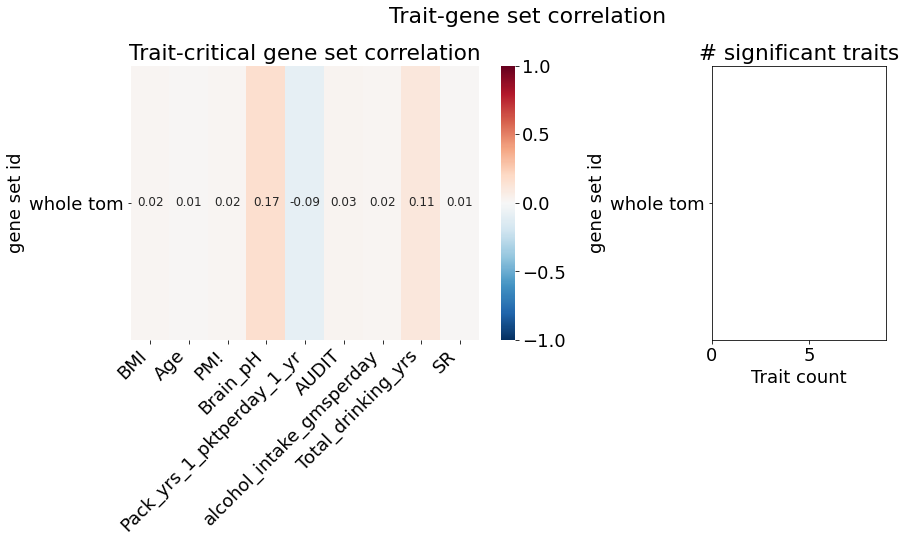

In [114]:
gene_set_phenotype_corr([tom_important_genes_sorted], ['whole tom'], expression_meta_df, 'top 10 genes')

# Determine if the distance between 2 nodes were the same in different embeddings

In [74]:
subnetwork_names = []
for deg, non_deg in zip([[4],[4],[4],[4],[4]], [[0],[1],[2],[3],[]]):
    network_name = f'module{deg}_n_{non_deg}_df'
    subnetwork_names.append(network_name)
embedding_path = prefix +'/Shared drives/NIAAA_ASSIST/Data/embedding_derived/embedding_Jan12/'
emb_list = []
i = 0
for file in os.listdir(embedding_path):
    emb = pd.read_csv(embedding_path + file, index_col = 0)
    emb_list.append(emb)
    i += 1

In [82]:
from scipy.spatial import distance

In [80]:
common_genes = list(set(emb_list[0].index).intersection(emb_list[1].index))

In [93]:
for i in range(3):
    print(f'distance between {common_genes[1]} and {common_genes[2]} in embedding {subnetwork_names[i]}')
    print(distance.euclidean(emb_list[i].loc[common_genes[1]], emb_list[i].loc[common_genes[2]]))

distance between ENSG00000230989 and ENSG00000256463 in embedding module[4]_n_[0]_df
7.464864386186868
distance between ENSG00000230989 and ENSG00000256463 in embedding module[4]_n_[1]_df
9.288262776869686
distance between ENSG00000230989 and ENSG00000256463 in embedding module[4]_n_[2]_df
13.33871343543804
